In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

# from keras.utils import plot_model
from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

import math
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

In [102]:
from sklearn.preprocessing import MinMaxScaler

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [104]:
df = pd.read_csv('datasets/GHL/train_1500000_seed_11_vars_23.csv')[10000:]
df_test1 = pd.read_csv('datasets/GHL/40_Lev_corr_Temp_fault_seed_180_vars_23.csv')[10000:]
df_test2 = pd.read_csv('datasets/GHL/19_Lev_fault_Temp_corr_seed_62_vars_23.csv')[10000:]
df_test3 = pd.read_csv('datasets/GHL/04_Lev_fault_Temp_corr_seed_23_vars_23.csv')[10000:]

In [106]:
y1 = df_test1['ATTACK']
y2 = df_test2['ATTACK']
y3 = df_test3['ATTACK']

# Все нужные признаки по мнению авторов
all_cols = ['RT_level', 'RT_temperature.T', 'HT_temperature.T','inj_valve_act', 'heater_act']
# Числовые признаки
num_cols = ['RT_level', 'RT_temperature.T', 'HT_temperature.T']
# Категориальные признаки
cat_cols = ['inj_valve_act', 'heater_act']

df = df[all_cols]
df_test1 = df_test1[all_cols]
df_test2 = df_test2[all_cols]
df_test3 = df_test3[all_cols]

### Анализ данных

In [107]:
for i in cat_cols:
    val = list(df[i].unique())
    val1 = list(df_test1[i].unique())    
    val2 = list(df_test2[i].unique())    
    val3 = list(df_test3[i].unique())
    print(i, '-- df -', val, '| df_test1 -', val1, '| df_test2 -', val2,'| df_test3 -', val3)

inj_valve_act -- df - [1.0, 0.0] | df_test1 - [1.0, 0.0] | df_test2 - [1.0, 0.0] | df_test3 - [1.0, 0.0]
heater_act -- df - [0.0, 1.0] | df_test1 - [0.0, 1.0] | df_test2 - [0.0, 1.0] | df_test3 - [0.0, 1.0]


<b> Все категориальные признаки одинаковые и в Train, и в Test выборках

### Preprocessing

In [108]:
def preprocessing(data, window_size=3):
    # OneHot Категориальных признаков
#     data = pd.get_dummies(data, columns=['boundary.m_flow_in'])
    
    # Скалирование числовых признаков
    sc = StandardScaler()
    data_sc = sc.fit_transform(data[num_cols])
    data[num_cols] = data_sc
    
    # Окно
    data_w = data.values[np.arange(window_size)[None, :] + np.arange(data.shape[0]-window_size)[:, None]]
    return data_w

In [109]:
df_w = preprocessing(df[:500000], window_size=12)
df_test1_w = preprocessing(df_test1, window_size=12)
df_test2_w = preprocessing(df_test2, window_size=12)
df_test3_w = preprocessing(df_test3, window_size=12)

df_train_w = preprocessing(df[500000:700000], window_size=12)

### Модель

In [112]:
def init_model(timesteps, n_features, num_cells=64, dropout_rate=0.1, lr=0.01):
    lstm_autoencoder = Sequential()
    # Encoder
    lstm_autoencoder.add(LSTM(64, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
    lstm_autoencoder.add(LSTM(8, activation='tanh', return_sequences=False))
    lstm_autoencoder.add(RepeatVector(timesteps))
    # Decoder
    lstm_autoencoder.add(LSTM(8, activation='tanh', return_sequences=True))
    lstm_autoencoder.add(LSTM(64, activation='tanh', return_sequences=True))
    lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

    adam = Adam(lr)
    lstm_autoencoder.compile(loss='mse', optimizer=adam)

    cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    return lstm_autoencoder

def fit_model(x, model, epochs=5, batch_size=1000, validation_split=0.2):
    lstm_autoencoder_history = model.fit(x, x, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split,
                        verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
    return lstm_autoencoder_history

def plt_epoch_error(history):
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [113]:
timesteps = df_w.shape[1]
n_features = df_w.shape[2]

In [114]:
model = init_model(timesteps=timesteps, n_features=n_features)

In [115]:
history = fit_model(df_w, model)

Epoch 1/5
400/400 [==============================] - 126s 294ms/step - loss: 0.0271 - val_loss: 0.0019
Epoch 2/5
400/400 [==============================] - 106s 266ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/5
400/400 [==============================] - 113s 284ms/step - loss: 9.5145e-04 - val_loss: 6.3101e-04
Epoch 4/5
400/400 [==============================] - 113s 282ms/step - loss: 6.5970e-04 - val_loss: 0.0016
Epoch 5/5
400/400 [==============================] - 120s 300ms/step - loss: 5.8502e-04 - val_loss: 5.0072e-04


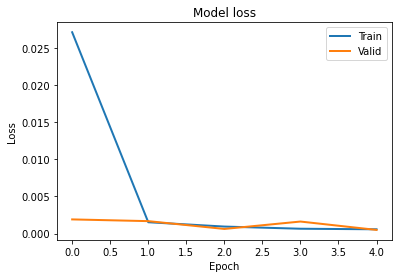

In [116]:
plt_epoch_error(history)

#### MSE

In [117]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X) 

def flatten_2(data):
    return np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))

def plt_mse(mse, title='MSE'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(mse)

In [118]:
pred_train = model.predict(df_train_w)

6250/6250 [==============================] - 82s 13ms/step


In [119]:
mse_train = np.mean(np.power(flatten_2(df_train_w) - flatten_2(pred_train), 2), axis=1)

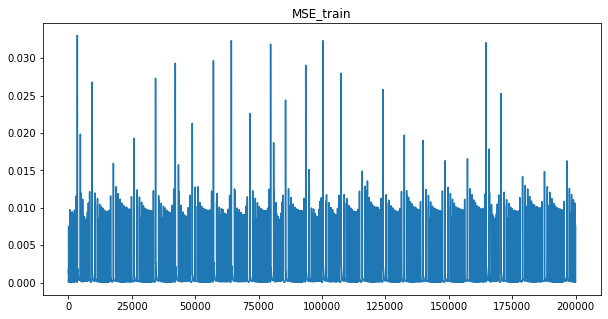

In [120]:
plt_mse(mse_train, title='MSE_train')

In [121]:
pred_test = model.predict(df_test1_w)

6080/6080 [==============================] - 83s 14ms/step


In [122]:
mse_test1 = np.mean(np.power(flatten_2(df_test1_w) - flatten_2(pred_test), 2), axis=1)

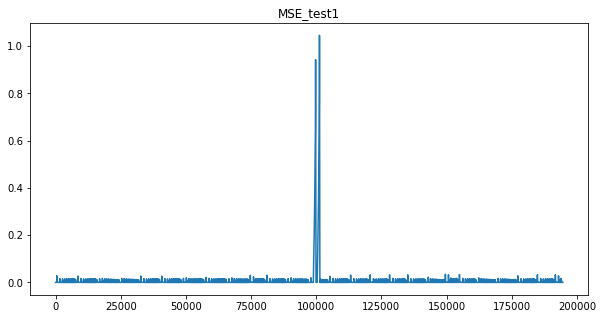

In [123]:
plt_mse(mse_test1, title='MSE_test1')

In [69]:
pred_test2 = model.predict(df_test2_w)

6089/6089 [==============================] - 66s 11ms/step


In [70]:
pred_test2.shape

(194824, 12, 5)

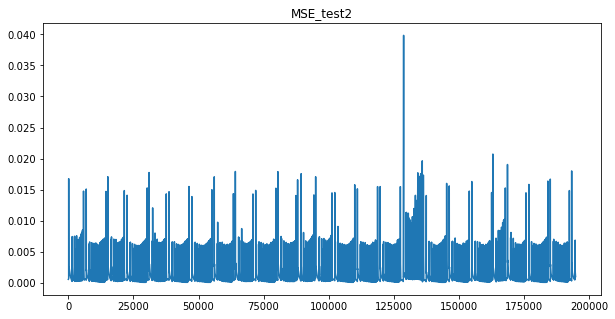

In [71]:
mse_test2 = np.mean(np.power(flatten_2(df_test2_w) - flatten_2(pred_test2), 2), axis=1)

plt_mse(mse_test2, title='MSE_test2')

6078/6078 [==============================] - 67s 11ms/step


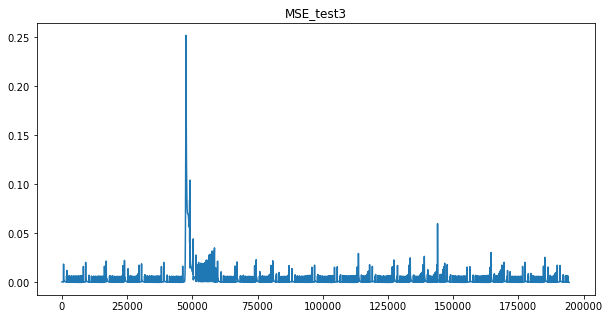

In [72]:
pred_test3 = model.predict(df_test3_w)

mse_test3 = np.mean(np.power(flatten_2(df_test3_w) - flatten_2(pred_test3), 2), axis=1)

plt_mse(mse_test3, title='MSE_test3')

### OCSVM

In [130]:
import math
from sklearn import svm

In [131]:
mse_train_rs = np.reshape(mse_train, (mse_train.shape[0], 1))

In [132]:
def change_label(label):
    arr = []
    for i in label: 
        if i == -1:
            arr.append(1)
        else:
            arr.append(0)
    return arr

def print_distrib(arr):
    labels = {}
    for i in arr:
        if i in labels.keys():
            labels[i] += 1
        else:
            labels[i] = 1
    print(labels)

In [133]:
mse_test1_rs = np.reshape(mse_test1, (mse_test1.shape[0], 1))

In [148]:
clf_1 = svm.OneClassSVM(nu=0.0021, kernel="rbf", gamma=0.1)
print('FIT....')
clf_1.fit(mse_train_rs)
print('FIT DONE')
print('PREDICT...')
y_scores_1 = clf_1.predict(mse_test1_rs)
print('PREDICT DONE')

anomaly1 = change_label(y_scores_1)
print_distrib(anomaly1)
print(f1_score(y1[12:], anomaly1))
print(classification_report(y1[12:], anomaly1))

FIT....
FIT DONE
PREDICT...
PREDICT DONE
{0: 192177, 1: 2369}
0.5883628478496566
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    191381
         1.0       0.69      0.51      0.59      3165

    accuracy                           0.99    194546
   macro avg       0.84      0.76      0.79    194546
weighted avg       0.99      0.99      0.99    194546



#### Подбираем гиперпраметры OCSVM

In [138]:
from time import time

num = 0
best_f1 = [0,0]
all_models = {}


for gamma in np.arange(0.05, 0.96, 0.05): # gamma    
    for nu in np.arange(0.002, 0.004, 0.0001): # NU
        start = time()
        print(num, " -- model FIT... -- nu:", nu, "| kernel: rbf", '| gamma:', gamma)
        clf_1 = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
        clf_1.fit(mse_train_rs)
        print('FIT DONE')
        print('PREDICT...')
        y_scores_1 = clf_1.predict(mse_test1_rs)
        print('PREDICT DONE')

        anomaly1 = change_label(y_scores_1)
        print_distrib(anomaly1)

        f1 = f1_score(y1[12:], anomaly1)


        if f1 > best_f1[1]:
            best_f1[0] = num
            best_f1[1] = f1
            all_models[num] = {'nu':nu, 'kernel':'rbf', 'gamma':gamma}
        num+=1

        print('-- F1: ', f1, ' -- TIME:', (time() - start))
        print('------------------------------------')

        

0  -- model FIT... -- nu: 0.002 | kernel: rbf | gamma: 0.05
FIT DONE
PREDICT...
PREDICT DONE
{1: 38347, 0: 156199}
-- F1:  0.0793023703989208  -- TIME: 16.244450092315674
------------------------------------
1  -- model FIT... -- nu: 0.0021 | kernel: rbf | gamma: 0.05
FIT DONE
PREDICT...
PREDICT DONE
{1: 41924, 0: 152622}
-- F1:  0.07416443034886558  -- TIME: 18.232597827911377
------------------------------------
2  -- model FIT... -- nu: 0.0021999999999999997 | kernel: rbf | gamma: 0.05
FIT DONE
PREDICT...
PREDICT DONE
{1: 44859, 0: 149687}
-- F1:  0.0705064134599367  -- TIME: 22.188647031784058
------------------------------------
3  -- model FIT... -- nu: 0.0022999999999999995 | kernel: rbf | gamma: 0.05
FIT DONE
PREDICT...
PREDICT DONE
{1: 47480, 0: 147066}
-- F1:  0.0674893869088755  -- TIME: 21.95327615737915
------------------------------------
4  -- model FIT... -- nu: 0.0023999999999999994 | kernel: rbf | gamma: 0.05
FIT DONE
PREDICT...
PREDICT DONE
{0: 192168, 1: 2378}
-- F1

FIT DONE
PREDICT...
PREDICT DONE
{0: 191988, 1: 2558}
-- F1:  0.5703302463742792  -- TIME: 33.404972553253174
------------------------------------
38  -- model FIT... -- nu: 0.003799999999999997 | kernel: rbf | gamma: 0.1
FIT DONE
PREDICT...
PREDICT DONE
{1: 50265, 0: 144281}
-- F1:  0.06475762680142243  -- TIME: 34.00815558433533
------------------------------------
39  -- model FIT... -- nu: 0.003899999999999997 | kernel: rbf | gamma: 0.1
FIT DONE
PREDICT...
PREDICT DONE
{1: 43808, 0: 150738}
-- F1:  0.07187107487279927  -- TIME: 34.4839608669281
------------------------------------
40  -- model FIT... -- nu: 0.002 | kernel: rbf | gamma: 0.15000000000000002
FIT DONE
PREDICT...
PREDICT DONE
{1: 37789, 0: 156757}
-- F1:  0.08013869219123895  -- TIME: 18.53862452507019
------------------------------------
41  -- model FIT... -- nu: 0.0021 | kernel: rbf | gamma: 0.15000000000000002
FIT DONE
PREDICT...
PREDICT DONE
{0: 192166, 1: 2380}
-- F1:  0.5871956717763752  -- TIME: 19.2513914108276

FIT DONE
PREDICT...
PREDICT DONE
{1: 48918, 0: 145628}
-- F1:  0.06601002246414377  -- TIME: 31.0677170753479
------------------------------------
74  -- model FIT... -- nu: 0.0033999999999999976 | kernel: rbf | gamma: 0.2
FIT DONE
PREDICT...
PREDICT DONE
{0: 192013, 1: 2533}
-- F1:  0.5728325728325728  -- TIME: 30.825502157211304
------------------------------------
75  -- model FIT... -- nu: 0.0034999999999999975 | kernel: rbf | gamma: 0.2
FIT DONE
PREDICT...
PREDICT DONE
{1: 62187, 0: 132359}
-- F1:  0.05560656139062309  -- TIME: 32.07670497894287
------------------------------------
76  -- model FIT... -- nu: 0.0035999999999999973 | kernel: rbf | gamma: 0.2
FIT DONE
PREDICT...
PREDICT DONE
{1: 64055, 0: 130491}
-- F1:  0.05486462362392145  -- TIME: 32.841975688934326
------------------------------------
77  -- model FIT... -- nu: 0.003699999999999997 | kernel: rbf | gamma: 0.2
FIT DONE
PREDICT...
PREDICT DONE
{0: 191973, 1: 2573}
-- F1:  0.5688393168351342  -- TIME: 33.835282564163

FIT DONE
PREDICT...
PREDICT DONE
{0: 192065, 1: 2481}
-- F1:  0.5773999291533829  -- TIME: 27.201972007751465
------------------------------------
111  -- model FIT... -- nu: 0.003099999999999998 | kernel: rbf | gamma: 0.3
FIT DONE
PREDICT...
PREDICT DONE
{1: 60088, 0: 134458}
-- F1:  0.05644001075047824  -- TIME: 29.59064269065857
------------------------------------
112  -- model FIT... -- nu: 0.003199999999999998 | kernel: rbf | gamma: 0.3
FIT DONE
PREDICT...
PREDICT DONE
{1: 18743, 0: 175803}
-- F1:  0.14898667153551212  -- TIME: 27.11749768257141
------------------------------------
113  -- model FIT... -- nu: 0.003299999999999998 | kernel: rbf | gamma: 0.3
FIT DONE
PREDICT...
PREDICT DONE
{1: 49010, 0: 145536}
-- F1:  0.06589362721609966  -- TIME: 27.3825740814209
------------------------------------
114  -- model FIT... -- nu: 0.0033999999999999976 | kernel: rbf | gamma: 0.3
FIT DONE
PREDICT...
PREDICT DONE
{1: 59750, 0: 134796}
-- F1:  0.05658428037828815  -- TIME: 32.565774202

FIT DONE
PREDICT...
PREDICT DONE
{1: 48559, 0: 145987}
-- F1:  0.06631351016936045  -- TIME: 21.920648097991943
------------------------------------
147  -- model FIT... -- nu: 0.002699999999999999 | kernel: rbf | gamma: 0.4
FIT DONE
PREDICT...
PREDICT DONE
{0: 192097, 1: 2449}
-- F1:  0.5806911293195582  -- TIME: 22.542134761810303
------------------------------------
148  -- model FIT... -- nu: 0.0027999999999999987 | kernel: rbf | gamma: 0.4
FIT DONE
PREDICT...
PREDICT DONE
{0: 192080, 1: 2466}
-- F1:  0.5789380216657787  -- TIME: 23.319283962249756
------------------------------------
149  -- model FIT... -- nu: 0.0028999999999999985 | kernel: rbf | gamma: 0.4
FIT DONE
PREDICT...
PREDICT DONE
{1: 54811, 0: 139735}
-- F1:  0.06054229336277079  -- TIME: 24.175982236862183
------------------------------------
150  -- model FIT... -- nu: 0.0029999999999999983 | kernel: rbf | gamma: 0.4
FIT DONE
PREDICT...
PREDICT DONE
{0: 192064, 1: 2482}
-- F1:  0.5772976801841685  -- TIME: 25.0786504

FIT DONE
PREDICT...
PREDICT DONE
{0: 192133, 1: 2413}
-- F1:  0.5844388669774113  -- TIME: 22.327598094940186
------------------------------------
184  -- model FIT... -- nu: 0.0023999999999999994 | kernel: rbf | gamma: 0.5
FIT DONE
PREDICT...
PREDICT DONE
{1: 45809, 0: 148737}
-- F1:  0.06934291664965082  -- TIME: 21.907414197921753
------------------------------------
185  -- model FIT... -- nu: 0.002499999999999999 | kernel: rbf | gamma: 0.5
FIT DONE
PREDICT...
PREDICT DONE
{0: 192111, 1: 2435}
-- F1:  0.5821428571428572  -- TIME: 23.79226040840149
------------------------------------
186  -- model FIT... -- nu: 0.002599999999999999 | kernel: rbf | gamma: 0.5
FIT DONE
PREDICT...
PREDICT DONE
{1: 48535, 0: 146011}
-- F1:  0.06634429400386846  -- TIME: 23.70145583152771
------------------------------------
187  -- model FIT... -- nu: 0.002699999999999999 | kernel: rbf | gamma: 0.5
FIT DONE
PREDICT...
PREDICT DONE
{0: 192096, 1: 2450}
-- F1:  0.5805877114870881  -- TIME: 25.61621356010

KeyboardInterrupt: 

In [147]:
print(best_f1[1])
print(all_models[best_f1[0]])

0.5883628478496566
{'nu': 0.0021, 'kernel': 'rbf', 'gamma': 0.1}


#### Получаем скор на всех аномальных датасетах

In [162]:
datasets = []

import os
for root, dirs, files in os.walk("datasets/GHL"):  
    for filename in files:
        datasets.append(str(filename))

In [165]:
datasets = datasets[:-1]

In [262]:
def get_score(data, model_nn, model_ocsvm, treshold):
    path = 'datasets/GHL/' + data
    
    # подгтовка данных
    data_df = pd.read_csv(path)[10000:]
    y = data_df['ATTACK']
    data_df_ = data_df[all_cols]
    data_df_w = preprocessing(data_df_, window_size=12)
    
    # получаем mse     
    pred = model_nn.predict(data_df_w)
    mse = np.mean(np.power(flatten_2(data_df_w) - flatten_2(pred), 2), axis=1)
    
    # Порог
    anomaly_treshold = []
    for i in mse:
        if i > treshold:
            anomaly_treshold.append(1.)
        else: anomaly_treshold.append(0.)
    f1_treshold = f1_score(y[:len(y)-12].values, anomaly_treshold)
    
    # классифицируем
    mse_rs = np.reshape(mse, (mse.shape[0], 1))
    y_scores = model_ocsvm.predict(mse_rs)
    anomaly = change_label(y_scores)
    f1_ocsvm = f1_score(y[:len(y)-12].values, anomaly)
    return f1_treshold, f1_ocsvm, mse


In [263]:
from tqdm import tqdm
from time import time

In [264]:
treshold = max(mse_train)

all_scores = {}
all_treshold_scores = {}
all_mse = {}

for i in tqdm(range(len(datasets))):
    start = time()
    f1_treshold, f1_ocsvm, mse = get_score(datasets[i], model, clf_1, treshold)
    
    all_treshold_scores[i+1] = f1_treshold
    all_scores[i+1] = f1_ocsvm
    all_mse[i+1] = mse
    
    print(i+1, 'DATA | F1_treshold --', round(f1_treshold, 4), '| F1_ocsvm --', round(f1_ocsvm, 4))
    print(time()-start)
    print('--------------')
    

  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

6080/6080 [==============================] - 121s 20ms/step


  2%|█▋                                                                              | 1/48 [02:16<1:46:47, 136.33s/it]

1 DATA | F1_treshold -- 0.0753 | F1_ocsvm -- 0.0812
136.3332917690277
--------------
6079/6079 [==============================] - 115s 19ms/step


  4%|███▎                                                                            | 2/48 [04:29<1:43:00, 134.35s/it]

2 DATA | F1_treshold -- 0.132 | F1_ocsvm -- 0.1174
132.96730613708496
--------------
6080/6080 [==============================] - 118s 19ms/step


  6%|█████                                                                           | 3/48 [06:43<1:40:40, 134.23s/it]

3 DATA | F1_treshold -- 0.1395 | F1_ocsvm -- 0.1387
134.07672023773193
--------------
6078/6078 [==============================] - 116s 19ms/step


  8%|██████▋                                                                         | 4/48 [08:55<1:37:53, 133.49s/it]

4 DATA | F1_treshold -- 0.1315 | F1_ocsvm -- 0.1219
132.36396479606628
--------------
6079/6079 [==============================] - 115s 19ms/step


 10%|████████▎                                                                       | 5/48 [11:07<1:35:07, 132.74s/it]

5 DATA | F1_treshold -- 0.1294 | F1_ocsvm -- 0.0848
131.40496182441711
--------------
6083/6083 [==============================] - 120s 20ms/step


 12%|██████████                                                                      | 6/48 [13:22<1:33:37, 133.76s/it]

6 DATA | F1_treshold -- 0.1227 | F1_ocsvm -- 0.1072
135.73985290527344
--------------
6085/6085 [==============================] - 118s 19ms/step


 15%|███████████▋                                                                    | 7/48 [15:36<1:31:28, 133.86s/it]

7 DATA | F1_treshold -- 0.0354 | F1_ocsvm -- 0.0708
134.07610702514648
--------------
6080/6080 [==============================] - 117s 19ms/step


 17%|█████████████▎                                                                  | 8/48 [17:50<1:29:10, 133.76s/it]

8 DATA | F1_treshold -- 0.038 | F1_ocsvm -- 0.0683
133.5504331588745
--------------
6082/6082 [==============================] - 117s 19ms/step


 19%|███████████████                                                                 | 9/48 [20:03<1:26:50, 133.61s/it]

9 DATA | F1_treshold -- 0.137 | F1_ocsvm -- 0.1202
133.25438261032104
--------------
6070/6070 [==============================] - 116s 19ms/step


 21%|████████████████▍                                                              | 10/48 [22:15<1:24:15, 133.05s/it]

10 DATA | F1_treshold -- 0.078 | F1_ocsvm -- 0.0606
131.81050896644592
--------------
6084/6084 [==============================] - 117s 19ms/step


 23%|██████████████████                                                             | 11/48 [24:28<1:22:00, 132.98s/it]

11 DATA | F1_treshold -- 0.051 | F1_ocsvm -- 0.0812
132.7997498512268
--------------
6086/6086 [==============================] - 116s 19ms/step


 25%|███████████████████▊                                                           | 12/48 [26:40<1:19:37, 132.71s/it]

12 DATA | F1_treshold -- 0.0597 | F1_ocsvm -- 0.077
132.09870886802673
--------------
6090/6090 [==============================] - 115s 19ms/step


 27%|█████████████████████▍                                                         | 13/48 [28:51<1:17:07, 132.21s/it]

13 DATA | F1_treshold -- 0.1092 | F1_ocsvm -- 0.1417
131.06711745262146
--------------
6087/6087 [==============================] - 117s 19ms/step


 29%|███████████████████████                                                        | 14/48 [31:06<1:15:18, 132.91s/it]

14 DATA | F1_treshold -- 0.145 | F1_ocsvm -- 0.1582
134.5209677219391
--------------
6087/6087 [==============================] - 117s 19ms/step


 31%|████████████████████████▋                                                      | 15/48 [33:19<1:13:10, 133.06s/it]

15 DATA | F1_treshold -- 0.0342 | F1_ocsvm -- 0.0647
133.4025046825409
--------------
6077/6077 [==============================] - 120s 20ms/step


 33%|██████████████████████████▎                                                    | 16/48 [35:35<1:11:25, 133.93s/it]

16 DATA | F1_treshold -- 0.0948 | F1_ocsvm -- 0.1049
135.94535565376282
--------------
6084/6084 [==============================] - 116s 19ms/step


 35%|███████████████████████████▉                                                   | 17/48 [38:11<1:12:37, 140.56s/it]

17 DATA | F1_treshold -- 0.1261 | F1_ocsvm -- 0.1321
155.9813950061798
--------------
6081/6081 [==============================] - 117s 19ms/step


 38%|█████████████████████████████▋                                                 | 18/48 [40:24<1:09:07, 138.25s/it]

18 DATA | F1_treshold -- 0.1366 | F1_ocsvm -- 0.1327
132.88448977470398
--------------
6089/6089 [==============================] - 116s 19ms/step


 40%|███████████████████████████████▎                                               | 19/48 [42:36<1:05:54, 136.36s/it]

19 DATA | F1_treshold -- 0.0796 | F1_ocsvm -- 0.1113
131.94606947898865
--------------
6080/6080 [==============================] - 115s 19ms/step


 42%|████████████████████████████████▉                                              | 20/48 [44:47<1:02:57, 134.89s/it]

20 DATA | F1_treshold -- 0.1469 | F1_ocsvm -- 0.1498
131.4730863571167
--------------
6090/6090 [==============================] - 115s 19ms/step


 44%|██████████████████████████████████▌                                            | 21/48 [46:58<1:00:10, 133.73s/it]

21 DATA | F1_treshold -- 0.0278 | F1_ocsvm -- 0.0671
131.01788425445557
--------------
6082/6082 [==============================] - 116s 19ms/step


 46%|█████████████████████████████████████▏                                           | 22/48 [49:10<57:39, 133.04s/it]

22 DATA | F1_treshold -- 0.1105 | F1_ocsvm -- 0.1243
131.43225049972534
--------------
6090/6090 [==============================] - 116s 19ms/step


 48%|██████████████████████████████████████▊                                          | 23/48 [51:21<55:14, 132.58s/it]

23 DATA | F1_treshold -- 0.1932 | F1_ocsvm -- 0.2032
131.48948884010315
--------------
6088/6088 [==============================] - 115s 19ms/step


 50%|████████████████████████████████████████▌                                        | 24/48 [53:32<52:51, 132.14s/it]

24 DATA | F1_treshold -- 0.0562 | F1_ocsvm -- 0.0915
131.1047170162201
--------------
6081/6081 [==============================] - 115s 19ms/step


 52%|██████████████████████████████████████████▏                                      | 25/48 [55:43<50:32, 131.84s/it]

25 DATA | F1_treshold -- 0.7612 | F1_ocsvm -- 0.6672
131.14768862724304
--------------
6082/6082 [==============================] - 115s 19ms/step


 54%|███████████████████████████████████████████▉                                     | 26/48 [57:55<48:16, 131.65s/it]

26 DATA | F1_treshold -- 0.4858 | F1_ocsvm -- 0.466
131.2217240333557
--------------
6079/6079 [==============================] - 115s 19ms/step


 56%|████████████████████████████████████████████▍                                  | 27/48 [1:00:05<45:56, 131.25s/it]

27 DATA | F1_treshold -- 0.5695 | F1_ocsvm -- 0.5509
130.29793190956116
--------------
6080/6080 [==============================] - 116s 19ms/step


 58%|██████████████████████████████████████████████                                 | 28/48 [1:02:16<43:43, 131.18s/it]

28 DATA | F1_treshold -- 0.564 | F1_ocsvm -- 0.5313
131.01562881469727
--------------
6081/6081 [==============================] - 112s 18ms/step


 60%|███████████████████████████████████████████████▋                               | 29/48 [1:04:22<41:05, 129.76s/it]

29 DATA | F1_treshold -- 0.7196 | F1_ocsvm -- 0.6053
126.44119215011597
--------------
6085/6085 [==============================] - 113s 19ms/step


 62%|█████████████████████████████████████████████████▍                             | 30/48 [1:06:31<38:48, 129.34s/it]

30 DATA | F1_treshold -- 0.6645 | F1_ocsvm -- 0.635
128.37021827697754
--------------
6080/6080 [==============================] - 116s 19ms/step


 65%|███████████████████████████████████████████████████                            | 31/48 [1:08:41<36:45, 129.73s/it]

31 DATA | F1_treshold -- 0.5254 | F1_ocsvm -- 0.4986
130.63212966918945
--------------
6076/6076 [==============================] - 112s 18ms/step


 67%|████████████████████████████████████████████████████▋                          | 32/48 [1:10:48<34:20, 128.81s/it]

32 DATA | F1_treshold -- 0.7204 | F1_ocsvm -- 0.6112
126.65876722335815
--------------
6082/6082 [==============================] - 112s 18ms/step


 69%|██████████████████████████████████████████████████████▎                        | 33/48 [1:12:54<32:01, 128.08s/it]

33 DATA | F1_treshold -- 0.6837 | F1_ocsvm -- 0.6423
126.37978553771973
--------------
6082/6082 [==============================] - 112s 18ms/step


 71%|███████████████████████████████████████████████████████▉                       | 34/48 [1:15:00<29:44, 127.45s/it]

34 DATA | F1_treshold -- 0.6758 | F1_ocsvm -- 0.6465
125.98735690116882
--------------
6080/6080 [==============================] - 112s 18ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 35/48 [1:17:08<27:36, 127.40s/it]

35 DATA | F1_treshold -- 0.6697 | F1_ocsvm -- 0.6337
127.28764343261719
--------------
6081/6081 [==============================] - 111s 18ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 36/48 [1:19:14<25:23, 126.97s/it]

36 DATA | F1_treshold -- 0.75 | F1_ocsvm -- 0.7228
125.9453330039978
--------------
6081/6081 [==============================] - 111s 18ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 37/48 [1:21:20<23:12, 126.63s/it]

37 DATA | F1_treshold -- 0.5272 | F1_ocsvm -- 0.5047
125.84444785118103
--------------
6075/6075 [==============================] - 112s 18ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 38/48 [1:23:26<21:05, 126.58s/it]

38 DATA | F1_treshold -- 0.819 | F1_ocsvm -- 0.7189
126.44471263885498
--------------
6079/6079 [==============================] - 111s 18ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 39/48 [1:25:32<18:57, 126.36s/it]

39 DATA | F1_treshold -- 0.5824 | F1_ocsvm -- 0.5292
125.86992239952087
--------------
6080/6080 [==============================] - 111s 18ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 40/48 [1:27:38<16:49, 126.22s/it]

40 DATA | F1_treshold -- 0.6336 | F1_ocsvm -- 0.597
125.87245607376099
--------------
6089/6089 [==============================] - 111s 18ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 41/48 [1:29:44<14:43, 126.18s/it]

41 DATA | F1_treshold -- 0.66 | F1_ocsvm -- 0.5911
126.08808708190918
--------------
6076/6076 [==============================] - 111s 18ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 42/48 [1:31:50<12:36, 126.08s/it]

42 DATA | F1_treshold -- 0.7724 | F1_ocsvm -- 0.6346
125.84794878959656
--------------
6080/6080 [==============================] - 112s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 43/48 [1:33:56<10:30, 126.12s/it]

43 DATA | F1_treshold -- 0.8168 | F1_ocsvm -- 0.7514
126.22680592536926
--------------
6081/6081 [==============================] - 111s 18ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 44/48 [1:36:02<08:24, 126.04s/it]

44 DATA | F1_treshold -- 0.6082 | F1_ocsvm -- 0.5644
125.85702180862427
--------------
6082/6082 [==============================] - 112s 18ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 45/48 [1:38:08<06:18, 126.13s/it]

45 DATA | F1_treshold -- 0.632 | F1_ocsvm -- 0.5736
126.33002829551697
--------------
6085/6085 [==============================] - 112s 18ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 46/48 [1:40:14<04:12, 126.20s/it]

46 DATA | F1_treshold -- 0.6281 | F1_ocsvm -- 0.6106
126.37124419212341
--------------
6077/6077 [==============================] - 111s 18ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 47/48 [1:42:20<02:06, 126.04s/it]

47 DATA | F1_treshold -- 0.6216 | F1_ocsvm -- 0.57
125.657297372818
--------------
6082/6082 [==============================] - 112s 18ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [1:44:27<00:00, 130.57s/it]

48 DATA | F1_treshold -- 0.742 | F1_ocsvm -- 0.6935
126.64878034591675
--------------


#### Визуализация скора на всех датасетах

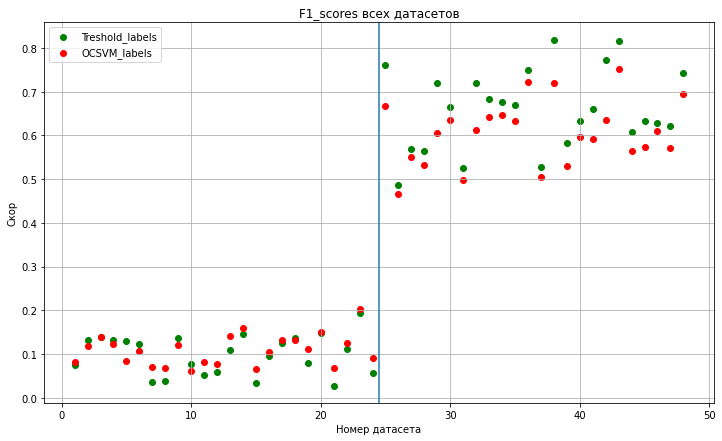

In [286]:
plt.figure(figsize=(12, 7))
plt.scatter(all_treshold_scores.keys(), all_treshold_scores.values(), color="g", label='Treshold_labels')
plt.scatter(all_scores.keys(), all_scores.values(), color="r", label='OCSVM_labels')
plt.axvline(24.5)
plt.title('F1_scores всех датасетов')
plt.xlabel('Номер датасета')
plt.ylabel('Скор')
plt.legend(loc='upper left')
plt.grid()
plt.grid(which='minor')

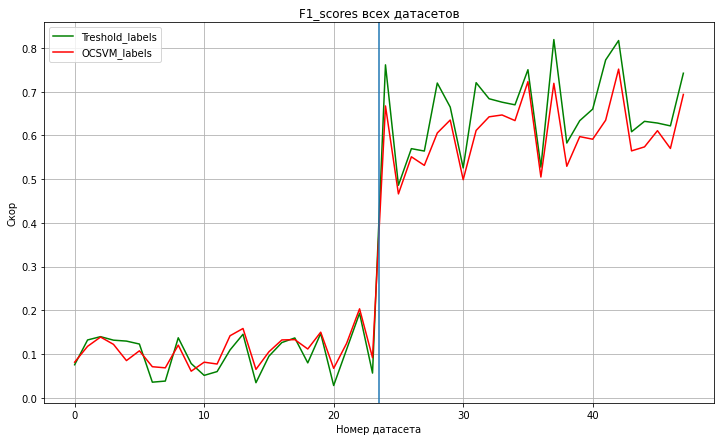

In [288]:
plt.figure(figsize=(12, 7))
plt.plot(all_treshold_scores.values(), color="g", label='Treshold_labels')
plt.plot(all_scores.values(), color="r", label='OCSVM_labels')
plt.axvline(23.5)
plt.title('F1_scores всех датасетов')
plt.xlabel('Номер датасета')
plt.ylabel('Скор')
plt.legend(loc='upper left')
plt.grid()
plt.grid(which='minor')

#### Визулизация реальных и предсказанных аномалий на рандомном датасете

In [214]:
path = 'datasets/GHL/' + datasets[47]
# подгтовка данных
data_df = pd.read_csv(path)[10000:]
y = data_df['ATTACK']
data_df_ = data_df[all_cols]
data_df_w = preprocessing(data_df_, window_size=12)
# получаем mse     
pred = model.predict(data_df_w)
mse = np.mean(np.power(flatten_2(data_df_w) - flatten_2(pred), 2), axis=1)
# классифицируем
mse_rs = np.reshape(mse, (mse.shape[0], 1))
y_scores = clf_1.predict(mse_rs)
anomaly = change_label(y_scores)
f1 = f1_score(y[12:], anomaly)
print(f1)

6082/6082 [==============================] - 114s 19ms/step
0.6845204711160964


In [235]:
treshold = max(mse_train)

anom1 = []

for i in mse:
    if i > treshold:
        anom1.append(1.)
    else: anom1.append(0.)

In [239]:
print(f1_score(y[:len(y)-12], anom1))

0.7420253948590895


Text(0.5, 1.0, 'TRESHOLD')

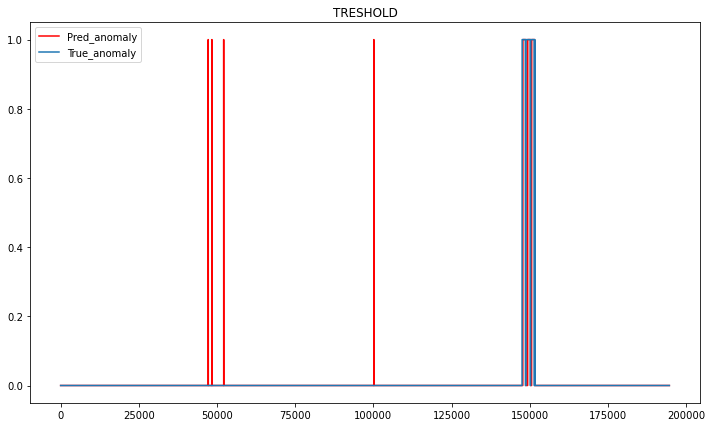

In [293]:
plt.figure(figsize=(12,7))
plt.plot(anom1, color='r', label='Pred_anomaly')
plt.plot(y[:len(y)-12].values, label='True_anomaly')
plt.legend(loc='upper left')
plt.title('TRESHOLD')
# plt.grid()

Text(0.5, 1.0, 'OCSVM')

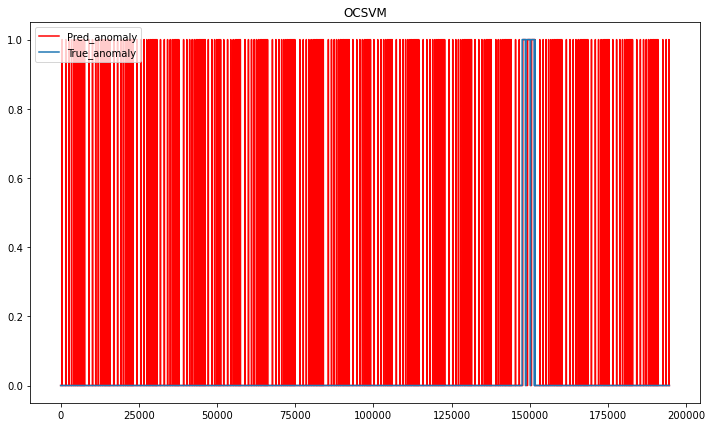

In [294]:
plt.figure(figsize=(12,7))
plt.plot(anomaly, color='r', label='Pred_anomaly')
plt.plot(y[:len(y)-12].values, label='True_anomaly')
plt.legend(loc='upper left')
plt.title('OCSVM')


In [216]:
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc

In [222]:
# desicion_func = clf_1.decision_function(mse_rs)

In [260]:
fpr,tpr,thresholds = roc_curve(y[12:], anom1)

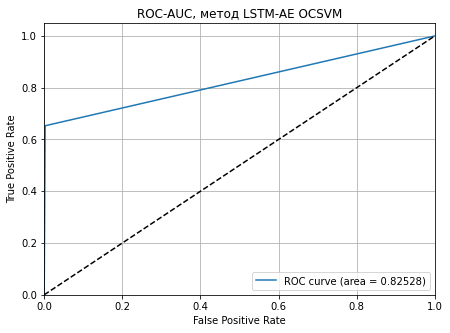

In [261]:
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC, метод LSTM-AE OCSVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()